## This notebook attempts to train and validate a DCTR model paramterized by the top mass only using reconstructed hadronic mass $m_{jjj}$ for each event

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [2]:
# standard library imports
from __future__ import absolute_import, division, print_function

import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras import Sequential
from keras.layers import Lambda, Dense, Input, Layer, Dropout
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import LambdaCallback, EarlyStopping
import keras.backend as K
import keras


import inspect

# standard numerical library imports
import numpy as np
import scipy as sp

# energyflow imports
import energyflow as ef
from energyflow.archs import PFN
from energyflow.utils import data_split, remap_pids, to_categorical

import matplotlib.pyplot as plt

Using TensorFlow backend.


## Process Data

In [3]:
# Path to downloaded data from Zenodo
data_dir = '/data1/users/aandreassen/DCTRFitting/'

In [4]:
# fetch m_T vals from default dataset
train_dataset_0_mT = np.load(data_dir + 'part_172_5_6j.npy')[:,:1,4] 

# fetch m_jjj vals from default dataset
train_dataset_0_mjjj = np.load(data_dir + 'part_172_5_6j_obs.npy')[:,0:1]

# fetch m_T vals from varied dataset
train_dataset_1_mT = np.load(data_dir + 'part_varmass_6j.npy')[:len(train_dataset_0_mT),:1,4]

# fetch m_jjj vals from varied dataset
train_dataset_1_mjjj = np.load(data_dir + 'part_varmass_6j_obs.npy')[:len(train_dataset_0_mjjj),0:1]

#### For each value of $m_T$ uniformally sampled, the model will see one event (one value of $m_{jjj}$) from varied $m_T$ and one from $m_T = 172.5$ (the defualt value).

In [5]:
X0 = np.concatenate((train_dataset_0_mjjj, train_dataset_1_mT), axis = 1)
X1 = np.concatenate((train_dataset_1_mjjj, train_dataset_1_mT), axis = 1)

In [6]:
Y0 = np.zeros_like(X0[:,0])
Y1 = np.ones_like(X1[:,0])

In [7]:
X = np.concatenate((X0, X1), axis = 0)

Y = np.concatenate((Y0, Y1), axis = 0)
Y = to_categorical(Y, num_classes=2)

In [8]:
X_train, X_val, Y_train, Y_val = data_split(X, Y, test=0.1, shuffle=True)

In [9]:
print(X_train.shape)
print(Y_train.shape)

print(X_val.shape)
print(Y_val.shape)


(103878, 2)
(103878, 2)
(11542, 2)
(11542, 2)


# Build Model

In [10]:
inputs = Input((2,))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)

outputs = Dense(2, activation='softmax')(hidden_layer_3)

dctr = Model(inputs = inputs, outputs = outputs)
dctr.compile(loss='categorical_crossentropy', optimizer='Adam')

# Train model

Model has a tendency to initialize at trivial minima of the loss function (loss ~ 8 or loss ~0). We do ~100 iterations of initializations to explore the fraction of initiziations that succeed in being able to train a non-trivial model(loss after first epoch ~1), and keep the weights from such a model to complete the rest of training.

In [11]:
earlystopping = EarlyStopping(patience = 10,
                              restore_best_weights=True)

count = 0
n_fail1 = 0
n_fail2 = 0
n_succ = 0

while True:
    count += 1
    print("Iteration: ", count)
    
    inputs = Input((2,))
    hidden_layer_1 = Dense(50, activation='relu')(inputs)
    hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
    hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)

    outputs = Dense(2, activation='softmax')(hidden_layer_3)
    
    dctr = Model(inputs = inputs, outputs = outputs)
    dctr.compile(loss='categorical_crossentropy', optimizer='Adam')
    
    history = dctr.fit(X_train, Y_train, 
              epochs=1, 
              batch_size = 1000,
              validation_data = (X_val, Y_val),
              callbacks = [earlystopping],
                            verbose = 1)
    if history.history['val_loss'][0] > 6: # Fail case 1
        n_fail1 += 1
    elif history.history['val_loss'][0] < 0.1: # Fail case 2
        n_fail2 += 1
    else: # success
        n_succ += 1
        if count > 99:
            break

n_fail = n_fail1 + n_fail2

Iteration:  1
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 103878 samples, validate on 11542 samples
Epoch 1/1





103878/103878 [==============================] - 1s 11us/step - loss: 8.0468 - val_loss: 8.1694
Iteration:  2
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 1s 8us/step - loss: 8.0713 - val_loss: 7.9487
Iteration:  3
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 1s 9us/step - loss: 8.0713 - val_loss: 7.9487
Iteration:  4
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 1s 10us/step - loss: 8.0468 - val_loss: 8.1694
Iteration:  5
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 1s 10us/step - loss: 0.8474 - val_loss: 0.6946
Iteration:  6
Train on 103878 samples, valida

103878/103878 [==============================] - 4s 39us/step - loss: 8.0468 - val_loss: 8.1694
Iteration:  38
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 4s 40us/step - loss: 1.2889 - val_loss: 0.6999
Iteration:  39
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 4s 41us/step - loss: 8.0468 - val_loss: 8.1694
Iteration:  40
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 4s 42us/step - loss: 8.0713 - val_loss: 7.9487
Iteration:  41
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 4s 43us/step - loss: 1.0111 - val_loss: 0.7047
Iteration:  42
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 5s 43us/step - loss: 8.0468 - val_loss: 8.1694
Iteration:  43
Train on 103878 samples, vali

Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 9s 85us/step - loss: 0.9569 - val_loss: 0.6937
Iteration:  86
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 9s 85us/step - loss: 0.7858 - val_loss: 0.6956
Iteration:  87
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 9s 89us/step - loss: 0.9194 - val_loss: 0.6937
Iteration:  88
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 9s 89us/step - loss: 0.8302 - val_loss: 0.6926
Iteration:  89
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 9s 89us/step - loss: 0.9826 - val_loss: 0.7306
Iteration:  90
Train on 103878 samples, validate on 11542 samples
Epoch 1/1
103878/103878 [==============================] - 10s 92us/step - loss: 8.0468 -

In [12]:
print("Number of initializations failed: ", n_fail, "/", count)
print("Percentage of initializations failed:", (100*n_fail/count), "%")

print("Number of initializations succeeded: ", n_succ, "/", count)
print("Percentage of initializations succeeded:", (100*n_succ/count), "%")

Number of initializations failed:  47 / 101
Percentage of initializations failed: 46.5346534653 %
Number of initializations succeeded:  54 / 101
Percentage of initializations succeeded: 53.4653465347 %


### Finish training

In [13]:
history = dctr.fit(X_train, Y_train, 
          epochs=200, 
          batch_size = 1000,
          validation_data = (X_val, Y_val),
          callbacks = [earlystopping],
                        verbose = 1)

Train on 103878 samples, validate on 11542 samples
Epoch 1/200
103878/103878 [==============================] - 1s 8us/step - loss: 0.7090 - val_loss: 0.7046
Epoch 2/200
103878/103878 [==============================] - 1s 8us/step - loss: 0.7169 - val_loss: 0.6942
Epoch 3/200
103878/103878 [==============================] - 1s 8us/step - loss: 0.7140 - val_loss: 0.6968
Epoch 4/200
103878/103878 [==============================] - 1s 7us/step - loss: 0.7124 - val_loss: 0.6962
Epoch 5/200
103878/103878 [==============================] - 1s 8us/step - loss: 0.7104 - val_loss: 0.7243
Epoch 6/200
103878/103878 [==============================] - 1s 8us/step - loss: 0.7153 - val_loss: 0.7036
Epoch 7/200
103878/103878 [==============================] - 1s 8us/step - loss: 0.7086 - val_loss: 0.7223
Epoch 8/200
103878/103878 [==============================] - 1s 8us/step - loss: 0.7101 - val_loss: 0.7193
Epoch 9/200
103878/103878 [==============================] - 1s 8us/step - loss: 0.7047 - val

# Plot History

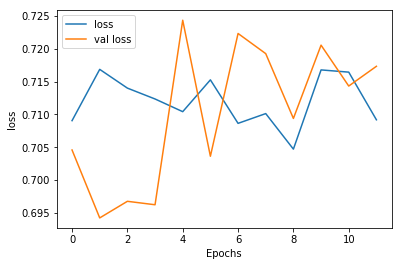

In [14]:
plt.plot(history.history['loss'],     label = 'loss')
plt.plot(history.history['val_loss'], label = 'val loss')
plt.legend(loc=0)
plt.ylabel('loss')
plt.xlabel('Epochs')
plt.show()

The network trained non-trivially, but still not the best.

## Load Datasets

In [15]:
test_dataset_0_mjjj = np.load(data_dir + 'part_172_5_6j_obs.npy')[:,:1]
test_dataset_1_mjjj = np.load(data_dir + 'part_175_0_6j_obs.npy')[:,:1]

X0_test = np.concatenate((test_dataset_0_mjjj, 172.5*np.ones_like(test_dataset_0_mjjj)), axis = 1)
X1_test = np.concatenate((test_dataset_0_mjjj, 175.0*np.ones_like(test_dataset_0_mjjj)), axis = 1)

In [16]:
# Define labels for legends
label_0 = r'$m_T=172.5$'

label_1 = r'$m_T=175.0$'

def make_legend():
    ax = plt.gca()
    leg = ax.legend(frameon=False)
    leg._legend_box.align = "left"
    plt.tight_layout()

## Get predictions

In [17]:
# Get predicted probabilities
preds_0 = dctr.predict(X0_test, batch_size=1000)
preds_1 = dctr.predict(X1_test, batch_size=1000)

In [18]:
print(preds_0[0:20]) # Network hasn't trained 
# outputs are all [1, 0] or all [0, 1] depending on random initialization

[[0.4971329  0.50286704]
 [0.5446043  0.4553956 ]
 [0.5025249  0.49747515]
 [0.4704579  0.5295421 ]
 [0.57284665 0.42715332]
 [0.47686836 0.52313167]
 [0.5073462  0.4926538 ]
 [0.45339146 0.5466085 ]
 [0.40380514 0.59619486]
 [0.5194878  0.48051223]
 [0.43860158 0.56139845]
 [0.47848344 0.52151656]
 [0.5362478  0.46375218]
 [0.5317689  0.4682311 ]
 [0.54160076 0.45839924]
 [0.4311025  0.5688974 ]
 [0.48023373 0.5197663 ]
 [0.492969   0.50703096]
 [0.49745217 0.50254786]
 [0.44318253 0.5568175 ]]


## Get weights

In [19]:
# calculate liklihood ratio as datasets are different lengths
liklihood_ratio = len(test_dataset_1_mjjj) / len(test_dataset_0_mjjj)
print(liklihood_ratio)

weights_0 = liklihood_ratio*preds_0[:,0]/preds_0[:,1]
weights_1 = liklihood_ratio*preds_1[:,0]/preds_1[:,1]

1.02441517935


## Analyze weights

In [20]:
print(max(weights_0))
print(max(1/weights_0))
print(max(weights_1))
print(max(1/weights_1))

56.269733
2.3994298
45.09652
2.5845342


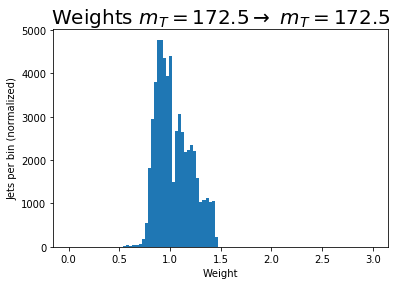

In [21]:
clip_val = 3
bins = np.linspace(0, clip_val, 101)
plt.hist(np.clip(weights_0, 0, clip_val), bins = bins)
plt.xlabel("Weight")
plt.ylabel('Jets per bin (normalized)')
plt.title("Weights " + label_0 + r'$\rightarrow$ ' + label_0, fontsize = 20)
plt.show()

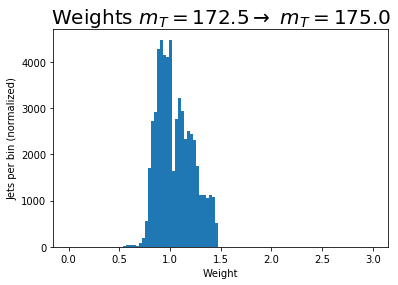

In [22]:
clip_val = 3
bins = np.linspace(0, clip_val, 101)
plt.hist(np.clip(weights_1, 0, clip_val), bins = bins)
plt.xlabel("Weight")
plt.ylabel('Jets per bin (normalized)')
plt.title("Weights " + label_0 + r'$\rightarrow$ ' + label_1, fontsize = 20)
plt.show()

In [23]:
# Define default plot styles
plot_style_0 = {'histtype':'step', 'color':'black', 'linewidth':2, 'linestyle':'--', 'density':True}
plot_style_1 = {'alpha':0.5, 'density':True}

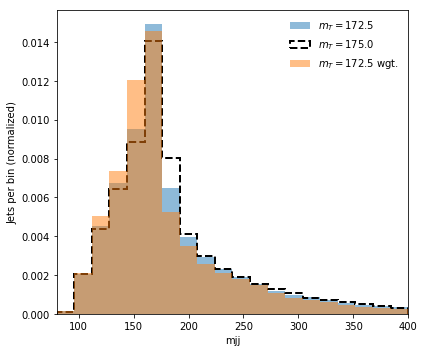

In [24]:
plt.figure(figsize=(6,5))
bins = np.linspace(80,400,21)
hist0 = plt.hist(test_dataset_0_mjjj, bins = bins, label = label_0, **plot_style_1)
hist1 = plt.hist(test_dataset_1_mjjj, bins = bins, label = label_1, **plot_style_0)
hist2 = plt.hist(test_dataset_0_mjjj, bins = bins, label = label_0 + ' wgt.', weights=weights_1, **plot_style_1)

plt.xlabel('mjj')
plt.ylabel('Jets per bin (normalized)')
plt.xlim([80,400])
make_legend()
plt.show()

Reweighting not successful enough